In [1]:
import simulacra.star
import simulacra.tellurics
from simulacra.star import PhoenixModel

import random
import numpy as np

import astropy.io.fits
import astropy.time as at

import astropy.units as u
import astropy.coordinates as coord
import astropy.constants as const

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


<h1>Simulacra: An Introduction to Simulating Spectrograph Data</h1>
This package should be used to simulate spectrographs by creating a star with a given flux, various transmission models (gas cell and tellurics), and a detector. Then simulating the detector at given start times for an exposure time.

### Theory
$$ F_{\lambda ij} t_{exp} A_{ste} \frac{A_{telescope}}{A_{sphere}} d \lambda_j = N
^{exp}_{ij}$$

### Sampling
c: read noise <br>
d: dark current <br>
Q: ccd efficiency <br>
f^{exp}: expected flux in photon number <br>
f^{readout}: readout flux in photon number

$$ SNR_{ij} = \frac{Q_j N^{exp}_{ij}}{\sqrt{c_j + d_j t_{exp} + Q_j N^{exp}_{ij}}} $$ <br>
$$ n_{ij} \sim Normal(0., 1/SNR_{i,j}) $$ <br>
$$ N^{readout}_{ij} = N^{exp}_{ij} + n_{ij}$$ <br>
$$ \sigma^{N}_{ij} = \frac{N^{readout}_{ij}}{SNR_{ij}} $$
Most in Nexp dominanted regime

through put 20%

1_000_000 photons is more normal.

this formula converts from the stellar flux denisty to the expected photon number on the detector.

In [2]:
ra, dec = np.random.uniform(0,360) * u.degree, np.random.uniform(0,80) * u.degree
obs = 'APO'
loc = coord.EarthLocation.of_site(obs)
target = coord.SkyCoord(ra,dec,frame='icrs')

Functions from the star module can be used to select times to view a given star from some observatory.

In [3]:
tstart = at.Time('2020-01-01T08:10:00.123456789',format='isot',scale='utc')
tend   = tstart + 365 * u.day
night_grid = simulacra.star.get_night_grid(loc,tstart,tend,steps_per_night=10)
possible_times, airmass = simulacra.star.get_realistic_times(target,loc,night_grid)

In [4]:
epoches = 4

Now we selected some random sample of these to observe at and the airmasses at those times

In [5]:
obs_ints = random.sample(range(len(airmass)),epoches)
obs_times, obs_airmass = possible_times[obs_ints], airmass[obs_ints]

<h2>Tellurics Model</h2>
The tellurics model requires these airmasses at the time of observation. However each of the pressure, temperatures, and humidities can be set by the user after initialization. If a single value is passed that is used for every epoch. Or you can pass it an array of quantities of size equal to the number of epoches.

In [6]:
wave_min = 920*u.nm
wave_max = 930*u.nm
tellurics_model = simulacra.tellurics.TelFitModel(wave_min,wave_max,loc)

Define some atmospheric parameters for the tellurics. These can either be constant over all time or an array with the same length as the number of epoches.

In [7]:
tellurics_model.pressure    = 875 * u.hPa
tellurics_model.temperature = 300 * u.Kelvin
tellurics_model.humidity    = 50.0

<h2>Star Model</h2>
Here we define the star model with some temperature, distance, logg, and companion parameters. The logg, T, z, and alpha parameters must correspond to an appropriate atmosphere model from the PHOENIX libraray online. Then also give it some companion parameters that could affect its velocity. This is what we will be trying to find use jabble.

z is metallicity. And distance can be set to whatever you want.

In [8]:
logg = 1.0
T    = 4800
z    = -1.0
alpha= 0.4
distance  = 20 * u.lyr
amplitude = 50 * u.m/u.s
period    = 65 * u.day
stellar_model = PhoenixModel(distance,alpha,z,T,logg,target,amplitude,period)

using saved wave file
data/stellar/PHOENIX/lte04800-1.00-1.0.Alpha=+0.40.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
using saved flux file
reading in data/stellar/PHOENIX/WAVE_PHOENIX-ACES-AGSS-COND-2011.fits


In [9]:
from simulacra.detector import Detector, spacing_from_res

<h2>Detector</h2>
Here we define our detector giving it an aperature area, resolution, dark current, read noise, and ccd efficiency. All of these can be except area can be given as an array of the same size as the wave_grid (eg. if the detector has varying resolution or noise levels)

In [10]:
resolution = 130_000
area = 10 * u.m**2
exp_times = 8 * np.ones(epoches)* u.minute 
dark_current = 1/u.s
read_noise   = 1
ccd_eff      = 0.99
through_put  = 0.2

delta_x = spacing_from_res(resolution)
x_grid = np.arange(np.log(wave_min.to(u.Angstrom).value),np.log(wave_max.to(u.Angstrom).value),delta_x)
wave_grid = np.exp(x_grid) * u.Angstrom

detector = Detector(stellar_model,resolution,loc,area,wave_grid,dark_current,read_noise,ccd_eff,through_put)

In [11]:
detector.add_model(tellurics_model)

<h2>Gas Cell</h2>
Optionally, add the gas cell to the detector for simulations of the Keck HiRES spectrograph.

In [12]:
# from simulacra.gascell import GasCellModel
# gascell_model = GasCellModel('data/gascell/keck_fts_inUse.idl')
# detector.add_model(gascell_model)

<h2>Simulator</h2>
Now comes the bulk of the work, run the simulation with the given transmission models, star, detector at the given times for some exposure times.

photon flux: 5.33e+20
ratios: 2.22e-35
exposures: 4.80e+02
star area: 3.46e+22
det flux: 3.93e+10


resetting...


generating spectra...
humidity: 50.0
 pressure: 875.0
 temperature: 300.0
 lat: 32.78000000000001
 elevation: 2.797999999999601
 freqmin(cm-1): 10752.68817204301
 freqmax(cm-1): 10869.565217391302
 angle: 37.411193583094985

humidity: 50.0
 pressure: 875.0
 temperature: 300.0
 lat: 32.78000000000001
 elevation: 2.797999999999601
 freqmin(cm-1): 10752.68817204301
 freqmax(cm-1): 10869.565217391302
 angle: 20.98256089657705

humidity: 50.0
 pressure: 875.0
 temperature: 300.0
 lat: 32.78000000000001
 elevation: 2.797999999999601
 freqmin(cm-1): 10752.68817204301
 freqmax(cm-1): 10869.565217391302
 angle: 25.9075126660496

humidity: 50.0
 pressure: 875.0
 temperature: 300.0
 lat: 32.78000000000001
 elevation: 2.797999999999601
 freqmin(cm-1): 10752.68817204301
 freqmax(cm-1): 10869.565217391302
 angle: 50.99166311821164

<simulacra.tellurics.TelFitModel object at 0x7fedf3b63630> [1.6178939059585673e-06, 2.2199421501056804e-07, 2.2199421501056804e-07, 2.2199421501056804e-07, 2.219942150105

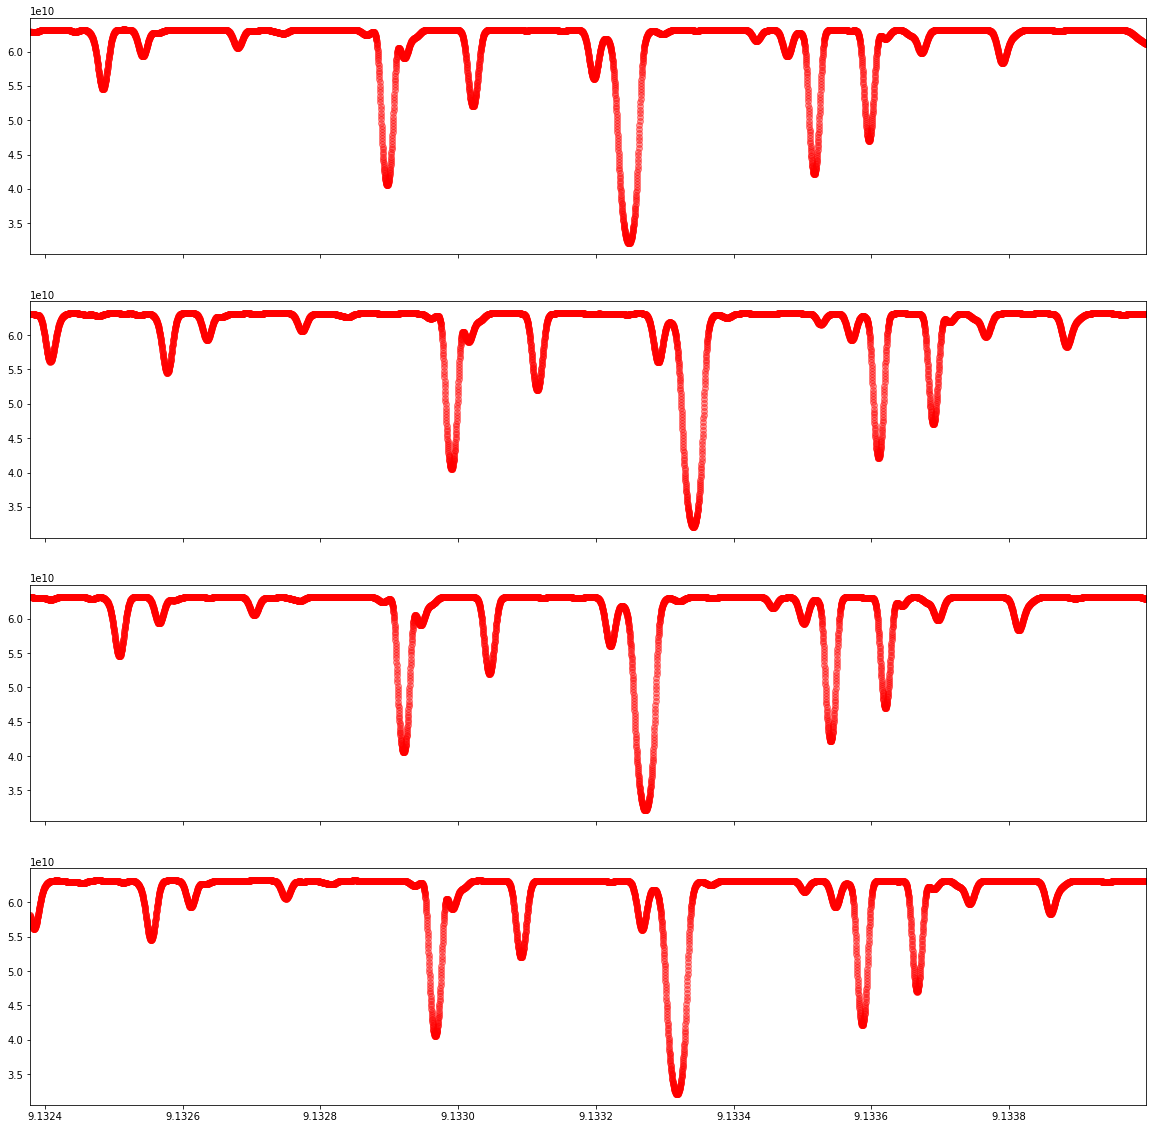

combining grids...
convolving...
0
1
2
3
interpolating lanczos...
f_exp 0: 56834550344.07536
f_exp 1: 57438535134.035126
f_exp 2: 57152076117.13308
f_exp 3: 55119996239.04986
generating signal to noise ratios...
1.0 480.0 31848578085.40411
1.0 480.0 54749717613.78239
1.0 480.0 58320978787.98895
1.0 480.0 31022372112.54073
1.0 480.0 57681109843.72023
1.0 480.0 59075372284.06941
1.0 480.0 31246879793.568573
1.0 480.0 54685944670.210434
1.0 480.0 58845349415.090355
1.0 480.0 31780153457.71748
1.0 480.0 55284548241.19412
1.0 480.0 56811574817.62375
adding noise...
snr 0: 237204.98093479246
snr 1: 238462.04990810528
snr 2: 237866.67390067386
snr 3: 233599.64841194777


In [13]:
data = detector.simulate(obs_times,exp_times)

Save file to pickle jar

In [14]:
filename = 'out/datatest5.pkl'
data.to_pickle(filename)
# data.to_h5('out/datatest4.h5')

In [15]:
import matplotlib.pyplot as plt
import scipy.ndimage
def normalize(y,yerr,sigma):
    y_low = scipy.ndimage.gaussian_filter(y,sigma)
    return y/y_low, yerr/y

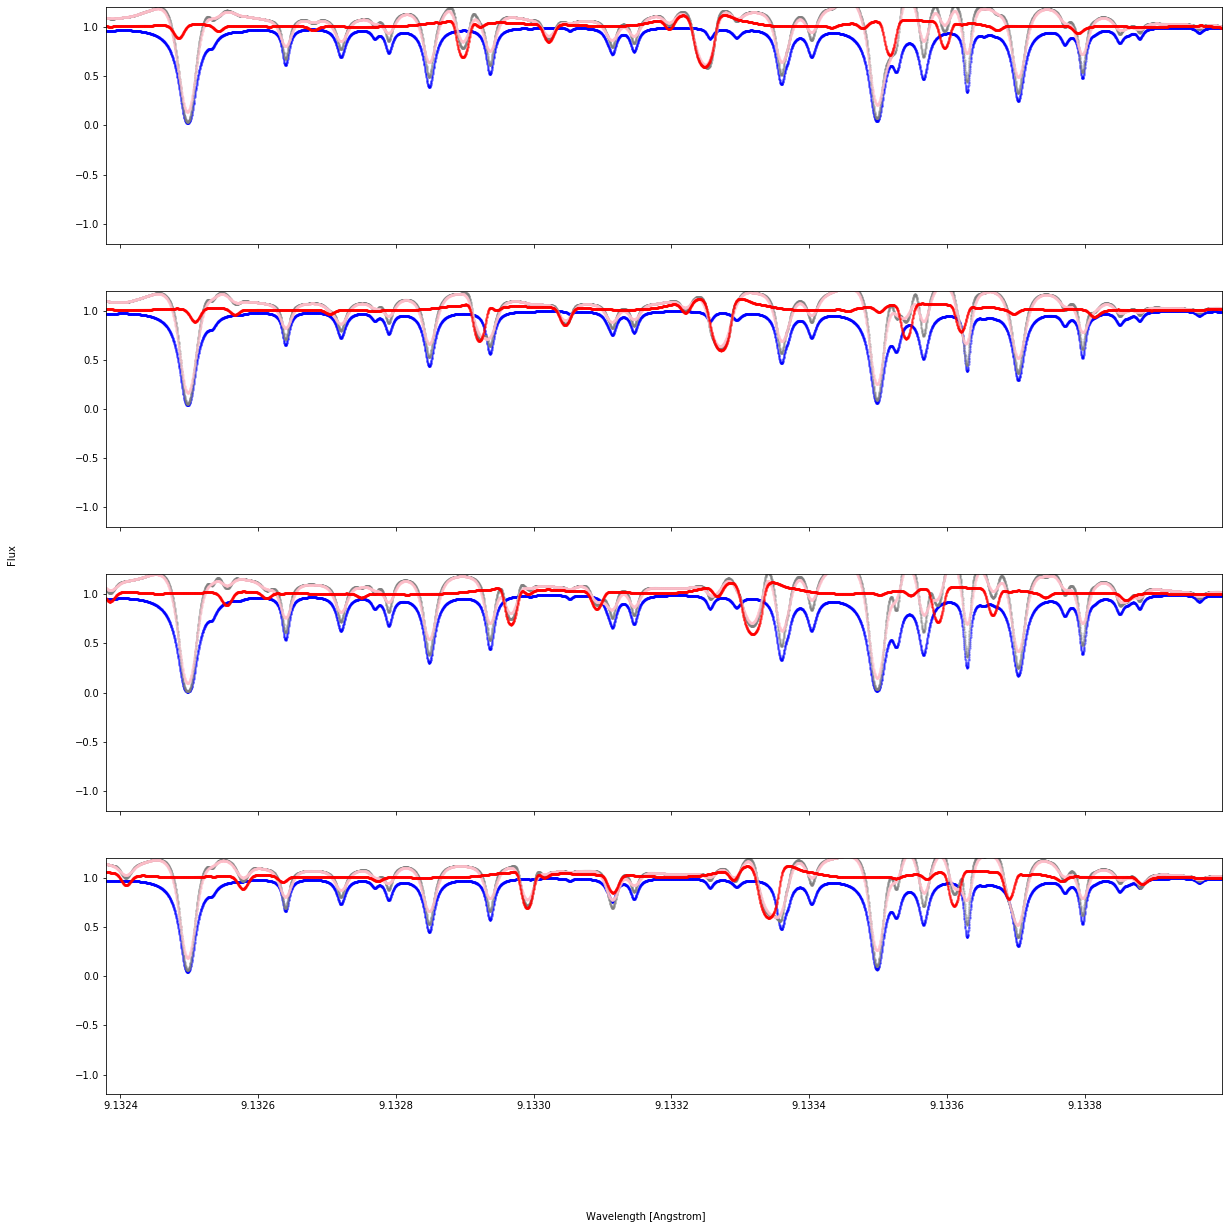

In [25]:
sigma = 200
n_plots = 4
plt_unit = u.Angstrom
sort_times = np.argsort(obs_times)
fig, axes = plt.subplots(n_plots,figsize=(20,5 * n_plots),sharex=True,sharey=True)

fig.text(0.5, 0.04, 'Wavelength [{}]'.format(plt_unit), ha='center', va='center')
fig.text(0.06, 0.5, 'Flux', ha='center', va='center', rotation='vertical')
for i in range(n_plots):
    axes[i].set_xlim(np.log(9250),np.log(9265))
    axes[i].set_ylim(-1.2,1.2)
#     data.plot_data(axes[i],sort_times[i],xy='x',units=plt_unit,normalize=normalize,nargs=[sigma])
    data.plot_tellurics(axes[i],sort_times[i],xy='x',units=plt_unit)
#     data.plot_gas(axes[i],sort_times[i],xy='x',units=plt_unit)
    data.plot_theory(axes[i],sort_times[i],xy='x',units=plt_unit,normalize=normalize,nargs=[sigma])
    data.plot_lsf(axes[i],sort_times[i],xy='x',units=plt_unit,normalize=normalize,nargs=[sigma])
    data.plot_star(axes[i],sort_times[i],xy='x',units=plt_unit,normalize=normalize,nargs=[sigma])
plt.savefig('out/datatest5.png')
plt.show()

(1406,) (4, 1406) (4, 1406)


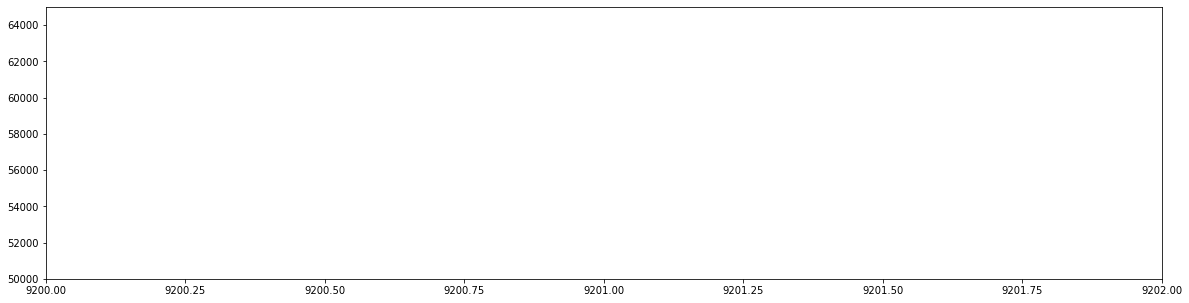

In [17]:
plt.figure(figsize=(20,5))
print(data['data']['wave'].shape,data['data']['flux'].shape,data['data']['ferr'].shape)
plt.errorbar(data['data']['wave'][:].to(u.Angstrom).value,data['data']['flux'][0,:],yerr=data['data']['ferr'][0,:],fmt='.k')
plt.ylim(5e4,0.65e5)
plt.xlim(9200,9202)
plt.show()

In [18]:
from simulacra.dataset import print_keys
print_keys(data)

data: <class 'dict'>
--obs_times: <class 'numpy.ndarray'>
--exp_times: <class 'astropy.units.quantity.Quantity'>
--epoches: <class 'int'>
--rvs: <class 'astropy.units.quantity.Quantity'>
--snr: <class 'numpy.ndarray'>
--flux_expected: <class 'numpy.ndarray'>
--flux: <class 'numpy.ndarray'>
--wave: <class 'astropy.units.quantity.Quantity'>
--ferr: <class 'numpy.ndarray'>
theory: <class 'dict'>
--star: <class 'dict'>
----deltas: <class 'astropy.units.quantity.Quantity'>
----flux: <class 'astropy.units.quantity.Quantity'>
----wave: <class 'astropy.units.quantity.Quantity'>
--interpolated: <class 'dict'>
----tellurics: <class 'dict'>
------flux: <class 'numpy.ndarray'>
----star: <class 'dict'>
------flux: <class 'numpy.ndarray'>
----total: <class 'dict'>
------flux: <class 'numpy.ndarray'>
------wave: <class 'astropy.units.quantity.Quantity'>
--tellurics: <class 'dict'>
----flux: <class 'numpy.ndarray'>
----wave: <class 'astropy.units.quantity.Quantity'>
--lsf: <class 'dict'>
----flux: <cl

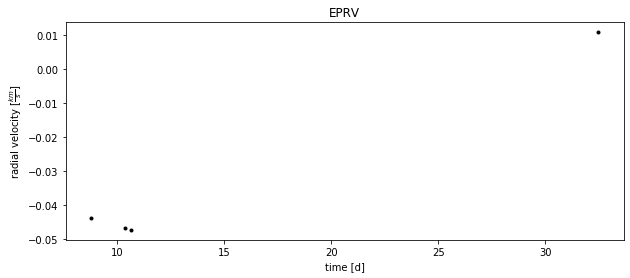

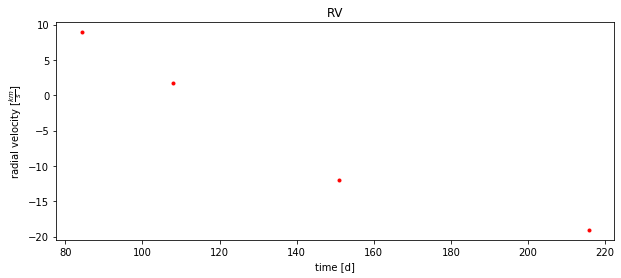

In [19]:
times = at.Time([obs_times[i] + exp_times[i]/2 for i in range(len(obs_times))])
periodic_times = np.array([(x-at.Time.now()).to(u.day).value % period.to(u.day).value for x in times])

rv = data['data']['rvs'].to(u.km/u.s)
bc  = target.radial_velocity_correction(obstime=times,location=loc).to(u.km/u.s)
eprv = rv - bc

plt.figure(figsize=(10,4))
plt.title('EPRV')
plt.plot(periodic_times,eprv.value,'.k')
plt.ylabel('radial velocity [$\\frac{km}{s}$]')
plt.xlabel('time [d]')
plt.show()

plt.figure(figsize=(10,4))
plt.title('RV')
plt.plot([(x - tstart).to(u.day).value for x in times],rv.value,'.r')
plt.ylabel('radial velocity [$\\frac{km}{s}$]')
plt.xlabel('time [d]')
plt.show()